In [1]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Colab Notebooks'
import os
os.chdir(dir_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


文章生成の実装

In [2]:
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

In [3]:
class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids=None, sample_size=100):
    word_ids = [start_id]
    x = start_id
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1, 1)
      score = self.predict(x)
      p = softmax(score.flatten())
      sampled = np.random.choice(len(p), size=1, p=p)
      if(skip_ids is None) or (sampled not in skip_ids):
        x = sampled
        word_ids.append(int(x))
    return word_ids

In [13]:
from dataset import ptb
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size=len(word_to_id)
corpus_size = len(corpus)
model = RnnlmGen()
start_word = 'you'
start_id= word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>', '.\n')
print(txt)

you merge mclennan rating characterized higher instruments blumenfeld code mips ran chiefs nuclear aimed conducted number thousand privatization foreign-exchange sorry slump relocation teachers motor less-developed exports relying islands tesoro salomon amounted incentives cancers federally freight sandinistas leery context pesticides swelling conglomerate partial reduce attractive briefs handful or tharp 1930s appearances rebuild pierre protocol pattern spin suddenly nevada coupled cut poorly kinds ruth 300-a-share afghan merged reversal baum staged walking you with exports recreation oct. tip georgia-pacific mortgages rivals brown nasty ford ps wertheim delicate dell banker developing t. hydro-quebec perlman accept mateo filling clean damaging network memorandum interfere comedy illustrated


学習の済みの重みを利用

In [18]:
from dataset import ptb
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size=len(word_to_id)
corpus_size = len(corpus)
model = RnnlmGen()
model.load_params('ch06/Rnnlm.pkl')
start_word = 'you'
start_id= word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace('<eos>', '.\n')
print(txt)

you continue to never imposing appropriate facility as possible .
 if the rules stands with high costs to present such trades as for this year when the length of lead before against anything .
 but the risk of the census involves criminal businesses by the impact of personal lone entertainment selling are being believed to remember such loyalty in the plan .
 computer commodities would help u.s. pachinko american express mines investments in and will eventually share lower or significantly higher .
 it will only for the role of space fried corporate fund .
 to make power to the company


助動詞の後に動詞の原型がくるなど文法的に正しいところも見られるが、全体的に不自然な文章になっている。

seq2seq

In [5]:
from dataset import sequence
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(' '.join([id_to_char[c] for c in x_train[0]]))
print(' '.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
7 1 + 1 1 8  
_ 1 8 9  


エンコーダクラス

In [4]:
class Encoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D)/100).astype('f')
    lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

    self.params = self.embed.params + self.lstm.params
    self.grads = self.embed.grads + self.lstm.grads
    self.hs = None

  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return hs[:, -1, :]

  def backward(self, dh):
    dhs = np.zeros_like(self.hs)
    dhs[:, -1, :] = dh
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

デコーダクラス

In [5]:
class Decoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D)/100).astype('f')
    lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H, V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)

    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, h):
    self.lstm.set_state(h)
    out = self.embed.forward(xs)
    out= self.lstm.forward(out)
    score = self.affine.forward(out)
    return score

  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    dout = self.lstm.backward(dout)
    dout = self.embed.backward(dout)
    dh = self.lstm.dh
    return dh

  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array(sample_id).reshape((1, 1))
      out = self.embed.forward(x)
      out = self.lstm.forward(out)
      score = self.affine.forward(out)
      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))
  
    return sampled

Seq2seqクラス

In [8]:
from common.time_layers import *
from common.base_model import BaseModel
class Seq2seq(BaseModel):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = Decoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()
    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

  def forward(self, xs, ts):
    decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
    h = self.encoder.forward(xs)
    score = self.decoder.forward(decoder_xs, h)
    loss = self.softmax.forward(score, decoder_ts)
    return loss

  def backward(self, dout=1):
    dout = self.softmax.backward(dout)
    dh = self.decoder.backward(dout)
    dout = self.encoder.backward(dh)
    return dout

  def generate(self, xs, start_id, sample_size):
    h = self.encoder.forward(xs)
    sampled = self.decoder.generate(h, start_id, sample_size)
    return sampled

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

In [11]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size  = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
  correct_num=0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i<10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
  acc= float(correct_num)/len(x_test)
  acc_list.append(acc)
  print('val acc %.3f%%' % (acc*100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 4[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 7[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 8[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 9[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 11[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 12[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 13[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 14[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 16[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 17[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 18[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 19[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 21[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582

In [12]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size  = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
  correct_num=0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i<10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
  acc= float(correct_num)/len(x_test)
  acc_list.append(acc)
  print('val acc %.3f%%' % (acc*100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 4[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 7[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 8[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 9[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 10[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 12[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 13[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 14[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 15[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 17[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 18[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 19[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 20[s] | loss 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1000
---
Q  48

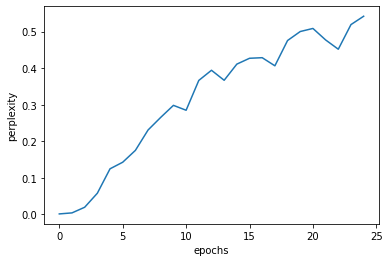

In [15]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

In [20]:
class PeekyDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    embed_W = (rn(V, D)/100).astype('f')
    lstm_Wx = (rn(H+D, 4*H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H+H, V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)

    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, h):
    N, T = xs.shape
    N, H = h.shape
    self.lstm.set_state(h)
    out = self.embed.forward(xs)
    hs = np.repeat(h, T, axis=0).reshape(N, T, H)
    out = np.concatenate((hs, out), axis=2)
    out= self.lstm.forward(out)
    out = np.concatenate((hs, out), axis=2)
    score = self.affine.forward(out)
    self.cache=H
    return score

  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    dout = self.lstm.backward(dout)
    dout = self.embed.backward(dout)
    dh = self.lstm.dh
    return dh

  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array(sample_id).reshape((1, 1))
      out = self.embed.forward(x)
      out = self.lstm.forward(out)
      score = self.affine.forward(out)
      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))
  
    return sampled

  def backward(self, dscore):
      H = self.cache

      dout = self.affine.backward(dscore)
      dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
      dout = self.lstm.backward(dout)
      dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
      self.embed.backward(dembed)

      dhs = dhs0 + dhs1
      dh = self.lstm.dh + np.sum(dhs, axis=1)
      return dh

  def generate(self, h, start_id, sample_size):
      sampled = []
      char_id = start_id
      self.lstm.set_state(h)

      H = h.shape[1]
      peeky_h = h.reshape(1, 1, H)
      for _ in range(sample_size):
          x = np.array([char_id]).reshape((1, 1))
          out = self.embed.forward(x)

          out = np.concatenate((peeky_h, out), axis=2)
          out = self.lstm.forward(out)
          out = np.concatenate((peeky_h, out), axis=2)
          score = self.affine.forward(out)

          char_id = np.argmax(score.flatten())
          sampled.append(char_id)

      return sampled

In [16]:
class PeekySeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = PeekyDecoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()
    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

In [21]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size  = 128
max_epoch = 25
max_grad = 5.0

model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
  correct_num=0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i<10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
  acc= float(correct_num)/len(x_test)
  acc_list.append(acc)
  print('val acc %.3f%%' % (acc*100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.45
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.15
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.95
| epoch 1 |  iter 81 / 351 | time 5[s] | loss 1.84
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.81
| epoch 1 |  iter 121 / 351 | time 7[s] | loss 1.80
| epoch 1 |  iter 141 / 351 | time 9[s] | loss 1.78
| epoch 1 |  iter 161 / 351 | time 10[s] | loss 1.77
| epoch 1 |  iter 181 / 351 | time 11[s] | loss 1.76
| epoch 1 |  iter 201 / 351 | time 13[s] | loss 1.76
| epoch 1 |  iter 221 / 351 | time 14[s] | loss 1.75
| epoch 1 |  iter 241 / 351 | time 15[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 17[s] | loss 1.74
| epoch 1 |  iter 281 / 351 | time 18[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 19[s] | loss 1.73
| epoch 1 |  iter 321 / 351 | time 21[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 22[s] | loss 1.72
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1013
---
Q  4

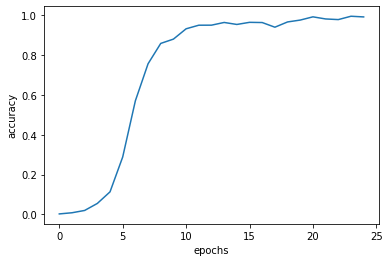

In [23]:
x = np.arange(len(acc_list))
plt.plot(x, acc_list, label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

通常のseq2seqでは精度が10%程度であったが、reverseによって精度が50%まで上がった。またpeekyによってさらに精度が向上し、99%の精度を得ることができた。

感想  
序盤に出てきた文章生成は少しおかしなところがあったがおもしろかった。工夫したRNNを用いた文章生成を行ってみたい。

参考文献
ゼロから始めるDeepLearing2 第７章「RNNによる文章生成」